# Analyzing Cold Damping Question Mark?

In this notebook, we are going to start analyzing the **Boib** dataset. We have datasets for three different pressures:
- 0.5 mbar
- 0.7 mbar
- 0.8 mbar

We expect the COM temperature to change by,

$T_\text{com} = T \frac{\Gamma_0}{\Gamma_0 + \delta \Gamma}$ where the $\delta \Gamma$ refers to the feedback gain.

In [2]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
from scipy.constants import k

# necessary constants and such
kBT = k*(273+22) # controlled room temperature
density = 1850 # kg/m^3
radius = 72e-9 # meter
mass = density*(4/3)*np.pi*radius**3 # kg

# np_tools

def available_channels(filename):
	"""
		A function that when given a filename for scopedata
		will find which channels are available and will return it
		in the form of `tABCD`
	"""
	first_line = ""
	with open(filename, "r") as file:
		# reads just the first line
		first_line = file.readline().strip()
	cols = [chan[-1] for chan in first_line.split(",")]
	cols[0] = "t"

	return "".join(cols)

def sampling_rate(df):
	# a function that returns the sampling rate of a DataFrame
	return 1/(df.t.iloc[1]-df.t.iloc[0])

def standardize_time(filename, data):
	"""
		A function that ensures that the dataset
		that is being used as its time series
		in seconds and not milliseconds
	"""
	units = ""
	with open(filename, "r") as file:
		cols = file.readline()
		# we only care about the second line that contains the unitws
		units = file.readline().strip()
	if "ms" in units:
		# if the time series is in ms, then convert to seconds
		data.t = data.t/1000 # converting from ms to s
	return data

## get the necessary functions in there as well


def Svv(f, f0, g0, c, floor):
	"""
		A fitting function in order to extract physical
		constants from the PSD of the signal
	"""
	return floor + c**2 * (g0*kBT/(np.pi*mass*(2*np.pi)**3)) /((f0**2 - f**2)**2 + f**2 * g0**2)

def spectral_fit(signal, sampling_freq, freq_mask, p0):
	"""
		Finds PSD using Welch's method and performs a 
		least squares fit to the expected spectrum.

		Returns filtered frequencies, PSD for those frequencies,
		eigenfrequency, damping rate, calibration factor, and the
		noise floor.
	"""
	f, ps = welch(signal, fs=sampling_freq, nfft=2**12)
	lo_f, hi_f = freq_mask
	f_filt = f[(lo_f < f) & (f < hi_f)]
	ps_filt = ps[(lo_f < f) & (f < hi_f)]

	popt, pcov = curve_fit(Svv, f_filt, ps_filt, p0=p0)

	f0, g0, c, floor = popt

	return f_filt, ps_filt, f0, g0, c, floor




In [9]:
boib_files = [f"boib/scope_fb_{pres}mbar.csv" for pres in ["0p5", "0p7", "0p8"]]
cols = available_channels(boib_files[0]) # extract columns
boib_data_08 = pd.read_csv("boib/scope_fb_0p8mbar.csv", skiprows=1, header=0, names=list(cols))
boib_data_07 = pd.read_csv("boib/scope_fb_0p7mbar.csv", skiprows=1, header=0, names=list(cols))
boib_data_05 = pd.read_csv("boib/scope_fb_0p5mbar.csv", skiprows=1, header=0, names=list(cols))
# refactor above code, i can't be bothered right now

boib_data_05 = standardize_time(boib_files[0], boib_data_05)
boib_data_07 = standardize_time(boib_files[0], boib_data_07)
boib_data_08 = standardize_time(boib_files[0], boib_data_08)

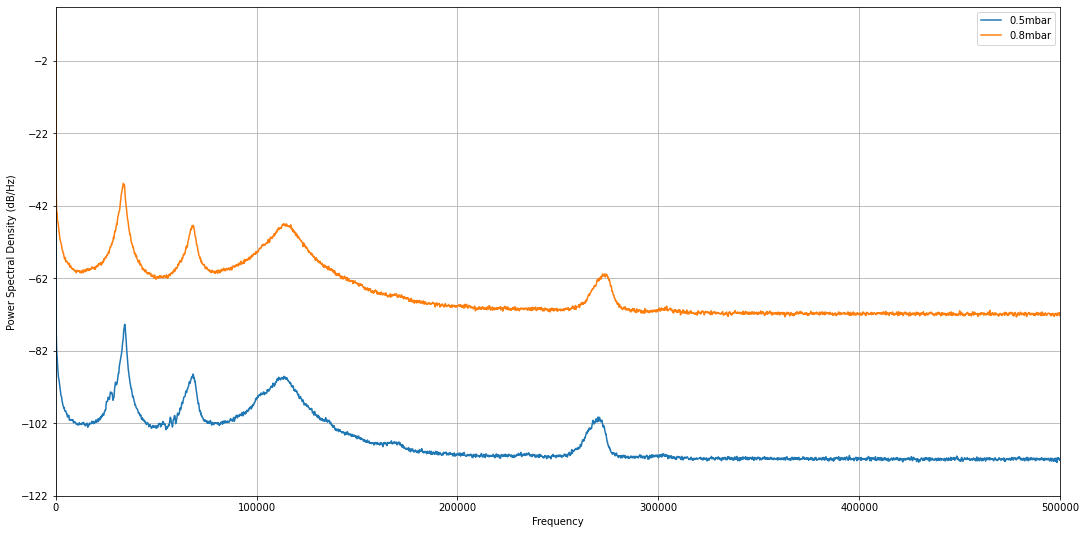

In [13]:
fs = sampling_rate(boib_data_05)
plt.figure(figsize=(18,9))

plt.psd(boib_data_05.B, Fs=fs, NFFT=2**15, label="0.5mbar")
plt.psd(100*boib_data_08.B, Fs=fs, NFFT=2**15, label="0.8mbar")
plt.xlim((0,500e3))
plt.legend(loc="upper right")
plt.show()

In [ ]:
# okay, so boib is a bit useless when it comes to the data we actually collected
# so let's try and do something else. let's try to see if we can salvage something frmo harry.
